In [57]:
# Imports and reproducibility
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from skfda import representation

In [58]:
# Read_ElNino_Data.py file for reading the data 
"""
This script contains the code for importing and pre-processing the simulation data sets
in the manuscript "Functional Autoencoder for Smoothing and Representation Learning".

@author: Sidi Wu
"""

import pandas as pd
import numpy as np
import os
import torch

os.chdir(r"D:\Mobina\Marquette\FAE Codes")

#####################################
### Real application: ElNino data set
#####################################
# Import dataset
x_raw = pd.read_csv('Dataset/ElNino_ERSST.csv')
tpts_raw = pd.read_csv('Dataset/ElNino_ERSST_tpts.csv')
label_table = pd.read_csv('Dataset/ElNino_ERSST_label.csv')
label = label_table.x.to_numpy()
time_grid = np.array(tpts_raw).flatten()

# Pre-process Data sets
# Prepare numpy/tensor data
x_np = np.array(x_raw).astype(float)
x = torch.tensor(x_np).float()
x_mean = torch.mean(x,0)
x = x - torch.mean(x,0)

# Rescale timestamp to [0,1]
tpts_np = np.array(tpts_raw)
tpts_rescale = (tpts_np - min(tpts_np)) / np.ptp(tpts_np)
tpts = torch.tensor(np.array(tpts_rescale))
n_tpts = len(tpts)


In [59]:
def build_basis_fc(tpts, n_basis=20, basis_type="Bspline"):
    """
    Create basis matrix evaluated on tpts.

    Returns:
        basis_fc: torch.Tensor of shape [n_basis, n_time]
                 (matches the style used in many FAE repos; we will handle orientation safely)
    """
    # tpts expected torch tensor [n_time] or [n_time,1]
    t = tpts.flatten().detach().cpu().numpy()
    t_min, t_max = float(t.min()), float(t.max())

    if basis_type == "Bspline":
        basis = representation.basis.BSpline(n_basis=n_basis, order=4)
    elif basis_type == "Fourier":
        basis = representation.basis.Fourier([t_min, t_max], n_basis=n_basis)
    else:
        raise ValueError("basis_type must be 'Bspline' or 'Fourier'")

    # skfda gives [n_time, n_basis, 1]
    eval_ = basis.evaluate(tpts.detach().cpu().numpy(), derivative=0)[:, :, 0]  # [n_time, n_basis]
    eval_ = torch.from_numpy(eval_).float()  # [n_time, n_basis]

    # We'll store as [n_basis, n_time] (like many FAE codes)
    return eval_.T

In [60]:
# Basis construction
def build_basis_fc(
    tpts: torch.Tensor,
    n_basis: int,
    basis_type: str
) -> torch.Tensor:
    """
    Returns basis evaluated on tpts as a torch tensor of shape [n_time, n_basis].
    """
    t_min = float(torch.min(tpts))
    t_max = float(torch.max(tpts))

    if basis_type == "Bspline":
        basis = representation.basis.BSpline(n_basis=n_basis, order=4)
    elif basis_type == "Fourier":
        basis = representation.basis.Fourier([t_min, t_max], n_basis=n_basis)
    else:
        raise ValueError(f"Unknown basis_type: {basis_type}")

    # skfda returns [n_time, n_basis, 1] for derivative=0
    eval_ = basis.evaluate(tpts, derivative=0)[:, :, 0]
    return torch.from_numpy(eval_).float()

In [61]:
# Model class (FAE) 
class FAEVanilla(nn.Module):
    def __init__(self, n_basis_project, n_rep, n_basis_revert, init_weight_sd=None):
        super().__init__()
        self.encoder = nn.Linear(n_basis_project, n_rep, bias=False)
        self.decoder = nn.Linear(n_rep, n_basis_revert, bias=False)
        self.activation = nn.Identity()  # linear model (same as your Opt 1)

        # optional weight init
        if init_weight_sd is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0.0, std=init_weight_sd)

    def project(self, x, tpts, basis_fc):
        """
        x: [batch, n_time]
        basis_fc: [n_basis, n_time]  (this function assumes this orientation)
        returns: [batch, n_basis]
        """
        t = tpts.flatten()
        dt = t[1:] - t[:-1]  # [n_time-1]

        # trapezoid weights
        zero = torch.zeros(1, device=x.device, dtype=x.dtype)
        W = 0.5 * torch.cat([zero, dt]) + 0.5 * torch.cat([dt, zero])  # [n_time]

        # (x * W) is [batch, n_time]
        # basis_fc.T is [n_time, n_basis]
        feature = (x * W) @ basis_fc.T
        return feature

    def revert(self, coef, basis_fc):
        """
        coef: [batch, n_basis]
        basis_fc: [n_basis, n_time]
        returns: [batch, n_time]
        """
        return coef @ basis_fc

    def forward(self, x, tpts, basis_fc_project, basis_fc_revert):
        feature = self.project(x, tpts, basis_fc_project)  # [batch, n_basis_project]
        rep = self.activation(self.encoder(feature))        # [batch, n_rep]
        coef = self.decoder(rep)                            # [batch, n_basis_revert]
        x_hat = self.revert(coef, basis_fc_revert)          # [batch, n_time]
        return x_hat, rep, feature, coef

In [62]:
# Loss + penalty
def diff_penalty(coef):
    """
    coef: [batch, n_basis]
    """
    delta = coef[:, 2:] - 2 * coef[:, 1:-1] + coef[:, :-2]
    return torch.mean(torch.sum(delta**2, dim=1))

In [63]:
# Train / evaluate helpers
def train_one_epoch(model, loader, optimizer, loss_fn, device,
                    tpts, basis_fc_project, basis_fc_revert,
                    pen="diff", lamb=0.0):

    model.train()
    total_loss = 0.0
    total_score_loss = 0.0
    n_batches = 0

    for x_batch in loader:
        x_batch = x_batch.to(device).float()

        optimizer.zero_grad()
        x_hat, rep, feature, coef = model(x_batch, tpts, basis_fc_project, basis_fc_revert)

        # main reconstruction loss
        loss = loss_fn(x_hat, x_batch)

        # optional feature-score loss (only meaningful if shapes match)
        score_loss = torch.tensor(0.0, device=device)
        if feature.shape == coef.shape:
            score_loss = loss_fn(feature, coef)
            total_score_loss += float(score_loss.detach().cpu())

        # penalty
        if pen == "diff" and lamb > 0:
            loss = loss + lamb * diff_penalty(coef)

        loss.backward()
        optimizer.step()

        total_loss += float(loss.detach().cpu())
        n_batches += 1

    return total_loss / max(n_batches, 1), total_score_loss / max(n_batches, 1)


@torch.no_grad()
def evaluate(model, x_data, loss_fn, device, tpts, basis_fc_project, basis_fc_revert):
    model.eval()
    x_data = x_data.to(device).float()
    x_hat, rep, feature, coef = model(x_data, tpts, basis_fc_project, basis_fc_revert)
    loss = loss_fn(x_hat, x_data)
    return x_hat, rep, float(loss.detach().cpu()), coef

In [64]:
# Full experiment loop (splits + training + LR)
def run_fae_experiment(
    x, label, tpts,
    n_iter=5,
    split_rate=0.8,
    epochs=2000,
    batch_size=28,
    n_rep=5,
    n_basis_project=20,
    n_basis_revert=20,
    basis_type_project="Bspline",
    basis_type_revert="Bspline",
    pen="diff",
    lamb=0.001,
    lr=1e-3,
    weight_decay=1e-6,
    init_weight_sd=0.5,
    log_every=100,
    device="cpu",
    seed=743
):
    # reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device(device)

    # build basis matrices once
    basis_fc_project = build_basis_fc(tpts, n_basis_project, basis_type_project).to(device)
    basis_fc_revert  = build_basis_fc(tpts, n_basis_revert,  basis_type_revert).to(device)
    tpts = tpts.to(device).float()

    loss_fn = nn.MSELoss()

    history = {
        "train_recon_loss": [],
        "test_recon_loss": [],
        "train_class_acc": [],
        "test_class_acc": [],
        "per_epoch_test_recon_loss": [[] for _ in range(epochs // log_every)],
        "per_epoch_test_class_acc": [[] for _ in range(epochs // log_every)],
    }

    n = x.shape[0]
    idx_all = np.arange(n)

    for r in range(n_iter):
        # split
        idx_train, idx_test = train_test_split(idx_all, train_size=split_rate, random_state=seed + r, shuffle=True)
        TrainData = x[idx_train]
        TestData  = x[idx_test]
        TrainLabel = np.asarray(label)[idx_train]
        TestLabel  = np.asarray(label)[idx_test]

        train_loader = DataLoader(TrainData, batch_size=batch_size, shuffle=True)

        # model is LOCAL (created fresh each replicate)
        model = FAEVanilla(n_basis_project, n_rep, n_basis_revert, init_weight_sd=init_weight_sd).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # training loop
        for epoch in range(1, epochs + 1):
            train_loss, score_loss = train_one_epoch(
                model, train_loader, optimizer, loss_fn, device,
                tpts, basis_fc_project, basis_fc_revert,
                pen=pen, lamb=lamb
            )

            if epoch % log_every == 0:
                _, reps_test, test_loss, _ = evaluate(model, TestData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)
                _, reps_train, _, _       = evaluate(model, TrainData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)

                clf = LogisticRegression(solver="liblinear", random_state=0, multi_class="auto")
                clf.fit(reps_train.cpu().numpy(), TrainLabel)
                test_acc = clf.score(reps_test.cpu().numpy(), TestLabel)

                k = (epoch // log_every) - 1
                history["per_epoch_test_recon_loss"][k].append(test_loss)
                history["per_epoch_test_class_acc"][k].append(test_acc)

                print(f"[rep {r+1}/{n_iter}] epoch {epoch:4d} | train={train_loss:.4f} | test={test_loss:.4f} | test_acc={test_acc:.4f}")

        # final evaluation
        _, reps_test, test_loss, _  = evaluate(model, TestData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)
        _, reps_train, train_loss, _ = evaluate(model, TrainData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)

        clf = LogisticRegression(solver="liblinear", random_state=0, multi_class="auto")
        clf.fit(reps_train.cpu().numpy(), TrainLabel)

        history["train_recon_loss"].append(train_loss)
        history["test_recon_loss"].append(test_loss)
        history["train_class_acc"].append(clf.score(reps_train.cpu().numpy(), TrainLabel))
        history["test_class_acc"].append(clf.score(reps_test.cpu().numpy(), TestLabel))

        print(f"Replicate {r+1} complete.\n")

    return history

In [65]:
# Implementation
history = run_fae_experiment(
    x=x,
    label=label,
    tpts=tpts,
    n_iter=1,
    epochs=2000,
    log_every=100
)

C:\Users\PC\AppData\Local\Temp\ipykernel_26684\156473771.py:14: DeprecationWarning: The BSpline class is deprecated. Use BSplineBasis instead.
  basis = representation.basis.BSpline(n_basis=n_basis, order=4)
C:\Users\PC\AppData\Local\Temp\ipykernel_26684\156473771.py:21: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  eval_ = basis.evaluate(tpts, derivative=0)[:, :, 0]
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver w

[rep 1/1] epoch  100 | train=0.3626 | test=0.3539 | test_acc=0.8214


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch  200 | train=0.2604 | test=0.2774 | test_acc=0.7679


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch  300 | train=0.1484 | test=0.1898 | test_acc=0.7321


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch  400 | train=0.1063 | test=0.1497 | test_acc=0.7321


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch  500 | train=0.0682 | test=0.0992 | test_acc=0.7500


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch  600 | train=0.0512 | test=0.0757 | test_acc=0.7321


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch  700 | train=0.0441 | test=0.0654 | test_acc=0.7321


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch  800 | train=0.0378 | test=0.0550 | test_acc=0.7679


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch  900 | train=0.0329 | test=0.0469 | test_acc=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch 1000 | train=0.0297 | test=0.0424 | test_acc=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch 1100 | train=0.0279 | test=0.0400 | test_acc=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch 1200 | train=0.0267 | test=0.0385 | test_acc=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch 1300 | train=0.0255 | test=0.0371 | test_acc=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch 1400 | train=0.0240 | test=0.0355 | test_acc=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch 1500 | train=0.0226 | test=0.0337 | test_acc=0.8036


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch 1600 | train=0.0211 | test=0.0320 | test_acc=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch 1700 | train=0.0202 | test=0.0309 | test_acc=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch 1800 | train=0.0193 | test=0.0302 | test_acc=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 1/1] epoch 1900 | train=0.0191 | test=0.0298 | test_acc=0.7857
[rep 1/1] epoch 2000 | train=0.0187 | test=0.0295 | test_acc=0.7857
Replicate 1 complete.



c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Use

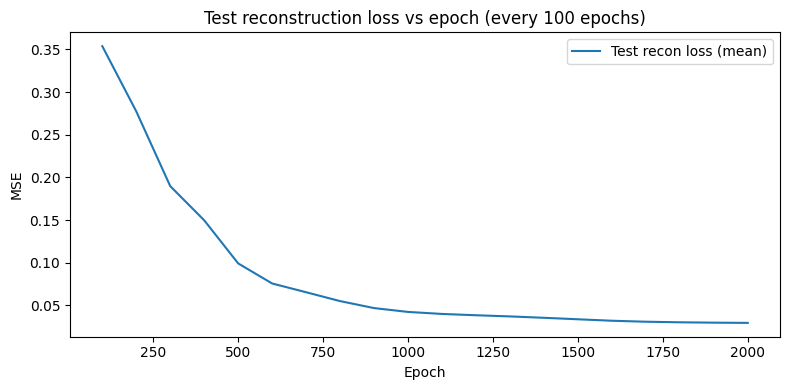

In [66]:
# Test reconstruction loss every 100 epochs (mean ± SD)
import numpy as np
import matplotlib.pyplot as plt

log_every = 100
epochs = 2000   # use your cfg.epochs

xs = np.arange(log_every, epochs + 1, log_every)

# Mean and SD across replicates
test_loss_mean = np.array([
    np.mean(v) for v in history["per_epoch_test_recon_loss"]
])
test_loss_sd = np.array([
    np.std(v) for v in history["per_epoch_test_recon_loss"]
])

plt.figure(figsize=(8,4))
plt.plot(xs, test_loss_mean, label="Test recon loss (mean)")
plt.fill_between(
    xs,
    test_loss_mean - test_loss_sd,
    test_loss_mean + test_loss_sd,
    alpha=0.25
)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Test reconstruction loss vs epoch (every 100 epochs)")
plt.legend()
plt.tight_layout()
plt.show()

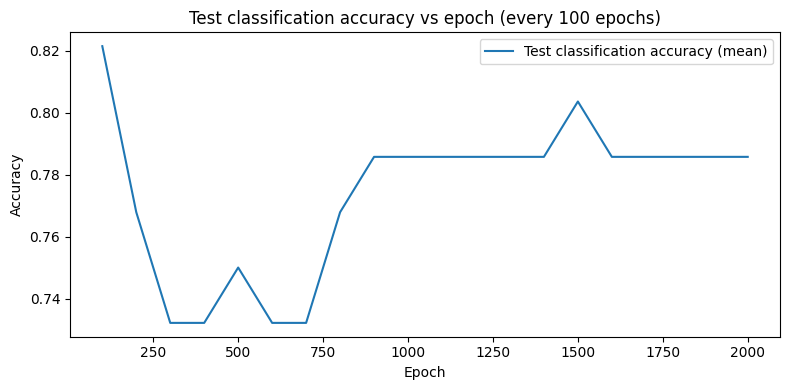

In [67]:
# Test classification accuracy every 100 epochs (mean ± SD)
test_acc_mean = np.array([
    np.mean(v) for v in history["per_epoch_test_class_acc"]
])
test_acc_sd = np.array([
    np.std(v) for v in history["per_epoch_test_class_acc"]
])

plt.figure(figsize=(8,4))
plt.plot(xs, test_acc_mean, label="Test classification accuracy (mean)")
plt.fill_between(
    xs,
    test_acc_mean - test_acc_sd,
    test_acc_mean + test_acc_sd,
    alpha=0.25
)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test classification accuracy vs epoch (every 100 epochs)")
plt.legend()
plt.tight_layout()
plt.show()